In [1]:
#get data

from msmbuilder.example_datasets import FsPeptide
fs_peptide = FsPeptide()
fs_peptide.cache()

In [2]:
import tempfile
import os
os.chdir(tempfile.mkdtemp())

In [3]:
from msmbuilder.dataset import dataset
xyz = dataset(fs_peptide.data_dir + "/*.xtc",
              topology=fs_peptide.data_dir + '/fs-peptide.pdb',
              stride=10)
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.5
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

C:\Anaconda2\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


28 trajectories
with length set([500.0]) ns


In [4]:
#featurization

from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = xyz.fit_transform_with(featurizer, 'diheds/', fmt='dir-npy')

print(xyz[0].xyz.shape)
print(diheds[0].shape)

(1000L, 264L, 3L)
(1000L, 84L)


In [5]:
#tICA

from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = diheds.fit_with(tica_model)
tica_trajs = diheds.transform_with(tica_model, 'ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

(1000L, 84L)
(1000L, 4L)


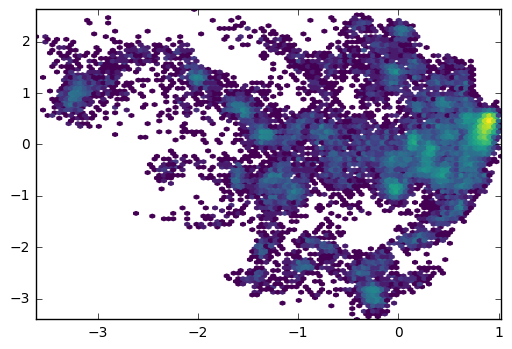

In [6]:
#histogram

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
txx = np.concatenate(tica_trajs)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')

In [7]:
#clustering

from msmbuilder.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=100)
clustered_trajs = tica_trajs.fit_transform_with(
    clusterer, 'kmeans/', fmt='dir-npy'
)

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(1000L, 4L)
(1000L,)


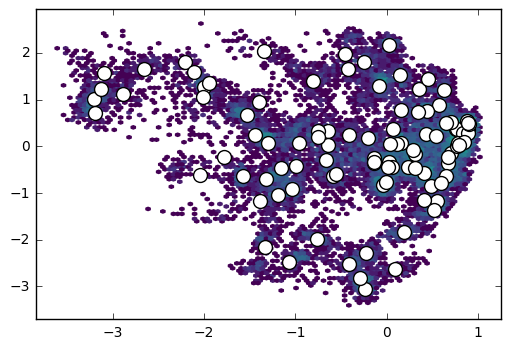

In [8]:
#show cluster

plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [9]:
#msm builder

from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=2, n_timescales=20)
msm.fit(clustered_trajs)

MSM contains 3 strongly connected components above weight=0.50. Component 1 selected, with population 95.433725%


MarkovStateModel(ergodic_cutoff='on', lag_time=2, n_timescales=20,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

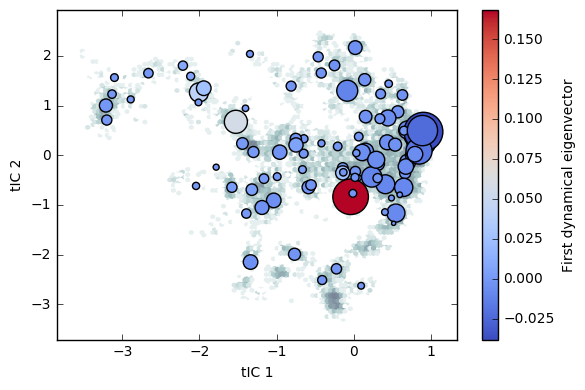

In [10]:
plt.hexbin(txx[:, 0], txx[:, 1], bins='log', mincnt=1, cmap="bone_r")
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm") 
plt.colorbar(label='First dynamical eigenvector')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.tight_layout()

In [11]:
msm.timescales_

array([ 2721.69702986,  1143.27719386,   854.28402551,   561.01415523,
         285.54495601,   250.85245805,   170.80282052,   149.83050811,
         127.87474017,   110.51148644,   107.72720386,    90.87604212,
          85.74669615,    80.67752394,    77.60737817,    68.05191419,
          61.85736269,    57.68973353,    55.04552862,    52.18244624])

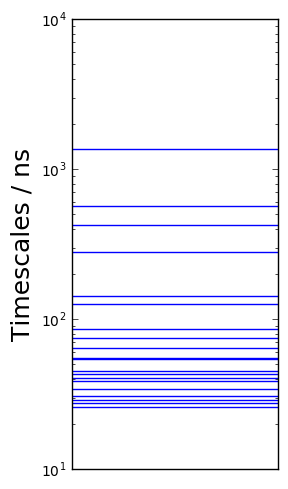

In [12]:

plt.subplots(figsize=(3,5))
plt.hlines(msm.timescales_ * to_ns, 0, 1, color='b')
plt.yscale('log')
plt.xticks([])
plt.ylabel("Timescales / ns", fontsize=18)
plt.tight_layout()

In [13]:
#macrostate model

from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(clustered_trajs)

Optimization terminated successfully.
         Current function value: -3.988976
         Iterations: 12
         Function evaluations: 122


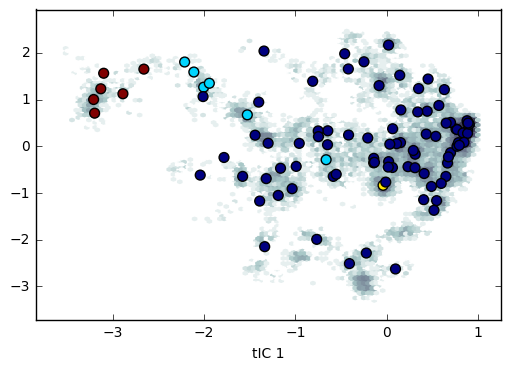

In [14]:
plt.hexbin(txx[:, 0], txx[:, 1], bins='log', mincnt=1, cmap="bone_r")
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
)
plt.xlabel('tIC 1')
#plt.ylabel('tIC 2')

In [15]:
#assigns every frame to a cluster

#Cluster locations: clusterer.cluster_centers_
#Frame locations: tica_trajs[0].shape

def intersect(a, b):
    """ return the intersection of two lists """
    return list(set(a) & set(b))

msm_labels = msm.state_labels_

cluster_location = []
for traj in tica_trajs:
    for frame in traj:
        error = np.linalg.norm(clusterer.cluster_centers_ - frame, axis=1)
        idx = error.argsort()[:4]
        idx = intersect(idx, msm_labels)
        cluster_location.append(idx[0])

In [16]:
#Now we have the transition matrix and frame cluster location

#print msm.transmat_
#print cluster_location[1:1000]

In [37]:
import mdtraj as md
file_location = "C:\\Users\\Christian\\Documents\\GitHub\\Protein_Dynamics_TJ\\MSM_Builder_Test\\Data\\"
t = md.load(file_location + "aligned_xyz_reconst.dcd", top=file_location + "fs-peptide.pdb")

t2 = []
for idx, trajectories in enumerate(xyz):
    if idx == 0:
        t2 = trajectories
    if idx != 0:
        t2 = t2.join(trajectories)
        

# print t.xyz.shape
# print xyz[0].xyz.shape
temp = xyz[0]
reference_frame = temp.slice(0, copy=True)

#t1 contains the linear path
#t2 contains all the frames
t.superpose(reference_frame)
t2.superpose(reference_frame)

C:\Anaconda2\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


<mdtraj.Trajectory with 28000 frames, 264 atoms, 23 residues, without unitcells at 0xf1c22b0>

In [73]:
true_frame_order = []
i = 0
for frame in t:
    rmsds = md.rmsd(t2, frame)
    true_frame_order.append(rmsds.argmin())
print true_frame_order

[550, 410, 490, 500, 450, 470, 430, 420, 360, 460, 370, 16290, 16300, 16320, 16310, 16230, 16260, 16180, 16240, 16170, 16200, 20860, 20950, 24600, 24510, 24550, 24620, 24530, 24480, 24520, 24660, 24680, 24720, 24750, 24800, 24790, 19750, 19060, 19600, 19240, 19200, 19330, 19530, 19540, 19070, 19490, 19100, 26590, 26620, 17210, 26810, 11160, 26860, 11200, 17190, 26520, 10050, 10080, 10040, 10140, 10270, 7730, 7770, 7670, 7750, 3560, 20980, 14200, 13130, 23520, 23160, 20650, 11830, 3380, 14560, 1700, 23290, 24440, 23440, 9280, 9270, 25760, 8540, 20100, 20340, 17680, 1740, 20350, 9840, 8570, 20230, 9880, 8560, 25530, 20170, 20190, 9870, 25490, 20120, 1750, 20290, 20020, 25810, 8580, 17380, 9520, 8400, 9430, 9630, 9790, 9960, 9970, 25480, 25890, 25570, 9440, 8450, 9450, 9560, 24890, 9500, 9800, 8350, 25620, 24960, 8200, 13790, 24250, 24090, 24040, 24020, 24010, 8020, 8010, 24140, 24220, 21850, 21860, 21970, 21620, 21960, 21830, 21930, 21920, 21870, 21630, 9740, 5370, 5070, 5270, 5490, 5230

In [71]:
#true_frame_order
#cluster_location

markov_traj = []
for num in true_frame_order:
    markov_traj.append(cluster_location[num])

print markov_traj

[22, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 32, 72, 72, 72, 33, 33, 33, 33, 33, 33, 40, 65, 40, 40, 65, 40, 40, 40, 40, 90, 58, 58, 58, 58, 58, 32, 49, 32, 32, 32, 32, 32, 32, 32, 32, 32, 57, 10, 10, 84, 84, 10, 84, 10, 40, 96, 96, 96, 25, 96, 80, 80, 80, 80, 80, 80, 80, 65, 80, 80, 80, 80, 65, 80, 80, 80, 80, 80, 80, 80, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 99, 39, 39, 39, 39, 39, 7, 39, 39, 39, 39, 7, 39, 39, 39, 7, 39, 39, 7, 7, 72, 2, 96, 2, 44, 2, 2, 44, 90, 90, 58, 90, 58, 58, 58, 36, 58, 90, 58, 58, 44, 44, 90, 3, 3, 97, 97, 97, 3, 97, 97, 97, 97, 3, 3, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97]


In [70]:
#check if reasonable result

for idx in range(0, len(markov_traj) - 1):
    first = idx
    second = idx + 1
    print msm.transmat_[markov_traj[first], markov_traj[second]]



0.00124566946853
0.783625648252
0.783625648252
0.783625648252
0.783625648252
0.783625648252
0.783625648252
0.783625648252
0.783625648252
0.783625648252
0.0
0.0
0.920415190481
0.920415190481
0.00529277036454
0.904977331569
0.904977331569
0.904977331569
0.904977331569
0.904977331569
0.0
0.0
0.0
0.97478991493
0.0
0.0
0.97478991493
0.97478991493
0.97478991493
0.0
0.0
0.631579108271
0.631579108271
0.631579108271
0.631579108271
0.0
0.0
0.0
0.974842761568
0.974842761568
0.974842761568
0.974842761568
0.974842761568
0.974842761568
0.974842761568
0.974842761568
0.0
0.0
0.933554812206
0.0
0.412499905616
0.0
0.0
0.0
0.0129626448531


IndexError: index 96 is out of bounds for axis 1 with size 96